## Agreements - All Articles

Vamos a ver los resultados del primer batch, que está etiquetado completo por dvalado y casi completo por gdamill

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

Primero, veamos qué usuarios etiquetaron más de 4 artículos...

In [2]:
from django.db.models import Count
from api.metrics import AgreementCalculator

articles = Article.objects.exclude(batch__name__in=["demo", "training"])

usernames = sorted([
    "asilva", 
    "fdesanctis", 
    "gdamill", 
    "dvalado", 
    "gclerici",
    "lprats",
])
users = [u for u in User.objects.filter(username__in=usernames)]

calculator = AgreementCalculator(articles=articles, users=users)



¿Cuántos etiquetamos todes?

## Agreements sobre odio

Ahora usamos sólo Alpha que da casi igual que Fleiss

In [3]:
import krippendorff

alpha, support = calculator.get_agreement("hate")

print(f"Alpha HATE para {' - '.join(calculator.usernames)}: {alpha:.3f} (soporte = {support})")


Alpha HATE para asilva - dvalado - fdesanctis - gclerici - gdamill - lprats: 0.599 (soporte = 6271)


Text(0.5, 1.0, 'Z-scores de annotator bias por clase')

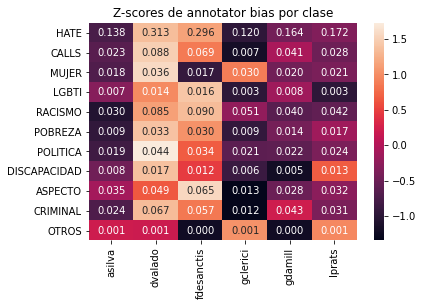

In [9]:
import matplotlib.pyplot as plt

import seaborn as sns

non_normalized = calculator.get_bias_all(zscore=False)
heatmap = calculator.get_bias_all(zscore=True)

sns.heatmap(heatmap, annot=non_normalized, fmt=".3f")
plt.title("Z-scores de annotator bias por clase")

## Sin sacar comentarios 

In [5]:
%%time
import pandas as pd

usernames = sorted([u.username for u in users])

agreements = pd.DataFrame(columns=usernames)

for i, u1 in enumerate(users):
    agreements.loc[u1.username, u1.username] = 1.0
    for j in range(i+1, len(users)):
        u2 = users[j]
        alpha, _ = calculator.get_agreement("hate", users=[u1.username, u2.username])
        agreements.loc[u1.username, u2.username] = alpha
        agreements.loc[u2.username, u1.username] = alpha

CPU times: user 3.27 s, sys: 132 µs, total: 3.27 s
Wall time: 3.29 s


In [6]:
agreements = agreements.astype(float)

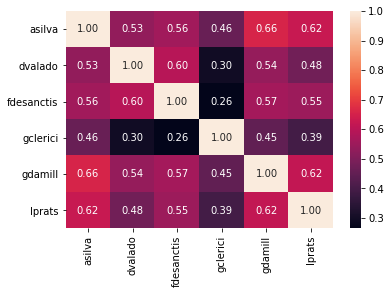

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import io

fig = sns.heatmap(agreements, fmt=".2f", annot=True)

buf = io.BytesIO()

plt.savefig(buf, format="png")

In [8]:
avg_agreement = (agreements.sum(axis=1)-1)/5

In [9]:
for k, v in avg_agreement.items():
    print(k, v)

asilva 0.5663972218443253
dvalado 0.4883503912412487
fdesanctis 0.5067890736416911
gclerici 0.37308636517451366
gdamill 0.5651879965509361
lprats 0.5321559380115568


Veamos qué porcentaje de comentarios etiquetan como odiosos

¿Cómo cambia el agreement sacando a cada uno de los anotadores?

In [10]:
for u in users:
    users_without = [username for username in usernames if username != u.username]
    alpha, _ = calculator.get_agreement("hate", users=users_without)
    print(f"- a {u.username:<12} ---> {alpha:.3f}")

- a asilva       ---> 0.571
- a dvalado      ---> 0.576
- a fdesanctis   ---> 0.571
- a gclerici     ---> 0.635
- a gdamill      ---> 0.562
- a lprats       ---> 0.566


In [13]:
calculator.get_agreement("hate", ["asilva", "dvalado", "lprats", "gdamill"])

(0.613946989475163, 5552)